#  Dynamic Programming and Monte Carlo Methods



<div class="alert alert-info">

In our second assignment, you will implement algorithms that were presented in the lectures on dynamic programming and on Monte Carlo methods. You can gain 25 points in total (+ up to 10 bonus points, if you also try yourself on TD learning). Please make sure that you do not overlook any of the questions.

<br>

For this assignment we will use OpenAI Gym (https://github.com/openai/gym). You can find the installation instruction on the very same page. For most systems "pip install gym" should be sufficient. In addition, you will need matplotlib ("pip install matplotlib").

Specifically, we will use the Frozen Lake environment (FrozenLake8x8-v0), which is quite similar to the Fishlake example we were using in class, and the Black Jack environment (Blackjack-v0).

<br>

To solve this exercise, read the notebook carefully from beginning to end and fill out coding parts and answer questions marked with **TODO**.

<br>

To make sure you do not forget any TODOs in this rather long notebook, here is a list:

- Implement DP Policy Evaluation (2 Points)
- Implement DP Policy Improvement (2 Points)
- Implement DP Policy Iteration (1 Point)
- Implement DP Value Iteration (6 Points)
- Implement MC Policy Evaluation (6 Points)
- Implement MC On-Policy Control (6 Points)
- Analysis of DP and MC on Frozen Lake (2 Point)
- Bonus: Implement TD Methods (up to 10 Points)

**Do not forget to run all the code cells, before saving and submitting the assignment!**

# Part 1: Frozen Lake

<div class="alert alert-info">




The following description is adapted from the environment description at https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py:

<pre><code>
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        
        SFFFFFFF
        FFFFFFFF
        FFFHFFFF
        FFFFFHFF
        FFFHFFFF
        FHHFFFHF
        FHFFHFHF
        FFFHFFFG
        
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
</code></pre>

You will now use this environment to implement prediction and control algorithms.


<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment and some helper functions. You have to run this cell first, before starting to implement and run your algorithms.

In [2]:
import numpy as np
import gym

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# load the environment
lake_env = gym.make('FrozenLake8x8-v0')
# reset it (set it back to its inital state (not strictly necessary here...))
lake_env.reset()

move_dict = {0: 'L', 1: 'D', 2: 'R', 3: 'U'} 


def deterministic_humanreadable_policy(env, policy, move_dict):
    """
    Generate a deterministic policy from a stochastic policy by taking
    the argmax action for every state. Then make it human-readable via 
    a given move dictionary
    
    Args:
        env: the openai gym environment
        policy: a policy given as np.array
        move_dict: dictionary, translating the move ids into a more human
        readable notation
    
    Returns:
        a human readable policy as np.array
    """
        
    deterministic_policy = np.array([np.argmax(policy[x]) for x in range(env.observation_space.n)])
    human_readable_policy = np.array([move_dict[x] for x in deterministic_policy])
    
    desc = env.env.desc.reshape(env.observation_space.n)
    for x in range(env.observation_space.n):
        if desc[x] in ('H', 'G'):
            human_readable_policy[x] = desc[x]
            
    return human_readable_policy.reshape((env.env.ncol, env.env.nrow))

## Quickstart

Here we give you a few hints on how to use the openai gym, what the data formats look like, etc.

### Loading the Environment and Moving Around

In [3]:
# load the environment
lake_env = gym.make('FrozenLake8x8-v0')
# reset it (set it back to its inital state (not strictly necessary here...))
lake_env.reset()
# let's start by looking at our environment
lake_env.render()
print("\n")

# we can try to move around:

result = lake_env.step(1) # let's try to move downwards
print(result)
print("\n")

# the result will look something like this:
# (8, 0.0, False, {'prob': 0.3333333333333333})
# which means that we are now in state 8, we got 0 reward for our last step,
# it is not a goal state and that the probability that we end up in this new state,
# given what our previous state and the action was, is 0.33 (so it is very very slippery)

# we can have another look at our environment (chances are that the agent moved away from the inital square)
lake_env.render()
print("\n")




SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


(0, 0.0, False, {'prob': 0.3333333333333333})


  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG




### Accessing Information about the Environment

In [4]:
# we have perfect information about our environment (and you should make use of it in your code...):
print("Shape: ", lake_env.env.ncol, lake_env.env.nrow) # we know the shape of our lake
print("Number of States: ", lake_env.env.observation_space.n) # we can also access the number of states directly
print("Number of Actions: ", lake_env.action_space.n) # we know the number of actions


# the dynamics are given as a dictionary (you can print the full dynamics by uncommenting the next line)
# print "Dynamics: ", env.env.P # and we know the dynamics

print("\nFor example, the dynamics for state 0 look like this:")
print(lake_env.env.P[0])
print("\nAnd if are in state 0 and take action 1, these are the dynamics:")
print(lake_env.env.P[0][1])

# i.e. env.env.P[x][y] gives you for state x and move y a list of possible outcomes.
# e.g. if we take action 1 at state 0, this is the result:
# [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False)]
# which means that with a probability of 0.33 we end up at state 0, get 0.0 reward, an it is a non-terminal state, etc.

# this means we can use dynamic programming to compute an optimal policy - and this is what you have to do now ;-)

Shape:  8 8
Number of States:  64
Number of Actions:  4

For example, the dynamics for state 0 look like this:
{0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}

And if are in state 0 and take action 1, these are the dynamics:
[(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False), (0.3333333333333333, 1, 0.0, False)]


### Storing the Policy and the Value Function

In [5]:
# wait, how do we store a policy?
# we simly use a 2-d np.array;
# the number of rows is given by the number of states,
# the number of columns is given by the number of actions:

# let's create a random walk policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

print("The Policy:\n")
print(policy)

# and the value function?
# again, we use a np.array

V = np.zeros(lake_env.observation_space.n)

print("\nA Value Function, initalised with 0:\n")
print(V)

print("\nWe can also print it in a nicer way:")
print(V.reshape((lake_env.env.ncol,lake_env.env.nrow)))

The Policy:

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25

## 1.1 Dynamic Programming: Policy Evaluation (2 points)

This is the first function you have to implement. We would suggest that you implement the in-place version of policy evaluation, as it is the simpler (and also the preferable) variant.

In [6]:
def policy_evaluation(env, policy, V=None, discount_factor=1.0, theta=0.0001):
    """
    Policy Evaluation via Dynamic Programming
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        V: the initial value function; if none is given, it is initialised with 0
        discount factor: discount factor gamma.
        theta: the stopping criterion
    
    Returns:
        the value function for a given policy
    """
    
    if V is None:
        V = np.zeros(env.observation_space.n)
    
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    v += action_prob*prob*(reward + discount_factor*V[next_state])
            delta = max(delta, np.abs(v-V[s]))
            V[s] = v
        if delta < theta:
            break
    return V


### Run DP Policy Evaluation 
Okay, let's now run the implemented algorithm on the fishlake environment.

In [7]:
# let's create a random policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

# our first policy
print("Our Policy:\n")
print(policy)

# and now let's see how good our policy is
policy_value = policy_evaluation(lake_env, policy)

# print the value function
print("\nThe Value Function of our Policy:\n")
print(policy_value.reshape((lake_env.env.ncol,lake_env.env.nrow)))

Our Policy:

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25

## 1.2 Dynamic Programming: Policy Improvement (2 points)

Here you have to implement the policy improvement algorithm. We will use this algorithm later on within the policy iteration algorithm to compute the optimal policy.

In [8]:
def policy_improvement(env, policy, V, discount_factor=1.0, theta=0.000001):
    """
    Policy Improvement
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        V: the value function of the policy
        discount_factor: discount factor gamma.
        theta: the stopping criterion
    
    Returns:
        a tuple consisting of
        the improved policy (a numpy array)
        and a boolean, indicating it the policy is stable (i.e. was not changed)
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    
    policy_stable = True
    
    for s in range(env.observation_space.n):
        # The best action taking under the current policy
        chosen_a = np.argmax(policy[s])
            
        # Find the best action by one-step lookahead
        action_values = one_step_lookahead(s, V)
        best_a = np.argmax(action_values)
            
        if chosen_a != best_a:
            policy_stable = False
        policy[s] = np.eye(env.nA)[best_a]
        
    
    return policy, policy_stable

## 1.3 Dynamic Programming: Policy Iteration (1 points)

This one should be easy now -- if you have correctly implemented the evaluation and the improvement algorithms above...

In [9]:
def policy_iteration(env, policy):
    """
    Policy Iteration
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    V = None
    policy_state=False
    
    while True:
        

        V = policy_evaluation(env,policy,V)
        new_policy, policy_stable = policy_improvement(env,policy,V)

        if policy_stable == True:
            
            break
            
        policy = new_policy.copy()
    
    return policy, V
    

### Run DP Policy Iteration

Next, let's improve a random policy and compute the optimal policy by using  policy iteration.

In [10]:
# let's create a random policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

# and now let's compute an optimal policy via the policy iteration algorithm
policy, value_function = policy_iteration(lake_env, policy)

# print the a human-readable version of the optimal policy
print("Policy computed via the policy iteration algorithm:\n")
print(deterministic_humanreadable_policy(lake_env, policy, move_dict))

print("\nand the respective value function:\n")
print(value_function.reshape((lake_env.env.ncol,lake_env.env.nrow)))

Policy computed via the policy iteration algorithm:

[['D' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'L' 'L' 'L' 'R' 'U' 'U' 'R']
 ['L' 'L' 'L' 'D' 'L' 'L' 'R' 'R']
 ['L' 'U' 'L' 'L' 'R' 'D' 'U' 'R']
 ['L' 'L' 'L' 'D' 'U' 'L' 'L' 'R']
 ['L' 'L' 'D' 'L' 'L' 'L' 'L' 'R']
 ['L' 'D' 'L' 'L' 'D' 'R' 'D' 'L']]

and the respective value function:

[[0.9996 0.9997 0.9997 0.9998 0.9998 0.9999 1.     1.    ]
 [0.9996 0.9997 0.9997 0.9998 0.9998 0.9999 1.     1.    ]
 [0.9988 0.9771 0.9256 0.     0.8564 0.9461 0.982  1.    ]
 [0.998  0.933  0.7999 0.4744 0.6233 0.     0.9446 1.    ]
 [0.9973 0.8238 0.5412 0.     0.5391 0.611  0.8519 1.    ]
 [0.9968 0.     0.     0.1679 0.383  0.4421 0.     1.    ]
 [0.9964 0.     0.194  0.1206 0.     0.3323 0.     1.    ]
 [0.9962 0.7287 0.4613 0.     0.2774 0.5549 0.7774 0.    ]]


## 1.4 Dynamic Programming: Value Iteration (6 points)

Implement the value iteration algorithm.

In [11]:
def value_iteration(env, V=None, theta=0.0000001, discount_factor=1.0):
    """
    Value Iteration
    
    Args:
        env: the openai gym environment
        V: a value function
        theta: the stopping criterion
        discount_factor: discount factor gamma
    
    Returns:
        a tuple consisting of
        the optimal policy
        and the respective value function
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    if V is None:
        
        V = np.zeros(env.observation_space.n)
        
        while True:
            # Stopping condition
            delta = 0
            # Update each state...
            for s in range(env.observation_space.n):
                # Do a one-step lookahead to find the best action
                A = one_step_lookahead(s, V)
                best_action_value = np.max(A)
                # Calculate delta across all states seen so far
                delta = max(delta, np.abs(best_action_value - V[s]))
                # Update the value function. Ref: Sutton book eq. 4.10. 
                V[s] = best_action_value        
            # Check if we can stop 
            if delta < theta:
                break
        
    policy = np.zeros([env.observation_space.n, env.action_space.n])
    
    for s in range(env.observation_space.n):
        
        A = one_step_lookahead(s,V)
        best_action = np.argmax(A)
        policy[s,best_action] = 1.0
    
    return policy, V

### Run DP Value Iteration

Finally, let's compute the optimal policy by using value iteration. Obviously the result should be very similar to the policy interation algorithm.

In [12]:
# let's redo this with value iteration...

# create a random policy
policy = np.ones([lake_env.observation_space.n, lake_env.action_space.n]) / lake_env.action_space.n

policy, value_function = value_iteration(lake_env)

print("\nPolicy computed via the value iteration algorithm:\n")
print(deterministic_humanreadable_policy(lake_env, policy, move_dict))

print("\nand the respective value function:\n")
print(value_function.reshape((lake_env.env.ncol,lake_env.env.nrow)))


Policy computed via the value iteration algorithm:

[['D' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'L' 'L' 'L' 'R' 'U' 'U' 'R']
 ['L' 'L' 'L' 'D' 'L' 'L' 'R' 'R']
 ['L' 'U' 'L' 'L' 'R' 'D' 'U' 'R']
 ['L' 'L' 'L' 'D' 'U' 'L' 'L' 'R']
 ['L' 'L' 'D' 'L' 'L' 'L' 'L' 'R']
 ['L' 'D' 'L' 'L' 'D' 'R' 'D' 'L']]

and the respective value function:

[[1.     1.     1.     1.     1.     1.     1.     1.    ]
 [1.     1.     1.     1.     1.     1.     1.     1.    ]
 [1.     0.9782 0.9264 0.     0.8566 0.9462 0.9821 1.    ]
 [1.     0.9346 0.8011 0.4749 0.6236 0.     0.9447 1.    ]
 [1.     0.8256 0.5422 0.     0.5393 0.6112 0.852  1.    ]
 [1.     0.     0.     0.168  0.3832 0.4423 0.     1.    ]
 [1.     0.     0.1947 0.1209 0.     0.3324 0.     1.    ]
 [1.     0.7316 0.4631 0.     0.2775 0.5549 0.7775 0.    ]]


# Part 2: Blackjack - A Model-free Environment

Let us now try Monte Carlo methods on a model-free environment (where it is very hard / impossible to use Dynamic Programming). We will use the game of Black Jack, as presented in the lecture. In general, MC methods are model free, but you might have used some convenience functions

<div class="alert alert-info">

The following description is adapted from the environment description at https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.

<h2>Preliminaries</h2>

What follows are the imports, the generation of the environment and some helper functions. You have to run this cell first, before starting to implement and run your algorithms.

In [13]:
import numpy as np
import gym

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# load the environment
blackjack_env = gym.make('Blackjack-v0')
# reset it (set it back to its inital state (not strictly necessary here...))
blackjack_env.reset()

(16, 10, True)

## Quickstart
Here we give you a few hints on how to use the Blackjack Environment, what the data formats look like, etc.

In [14]:
# let's load the Blackjack Environment
blackjack_env = gym.make('Blackjack-v0')
state = blackjack_env.reset()

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# this environment has no render function
# it does also not give access to the dynamics or the size of the state space
# so there is no way we can use dynamic programming here, we are forced to use model-free methods

# the only thing we know is the size of the action space:
print('We know the size of the action space:', blackjack_env.action_space.n)

# and what we can also get is the current state
print('This is what a state looks like: ' + str(state))

# when we reset the environment, our hand (the first two cards) and the dealer's hand are dealt
# then the game begins... (so everytime you run env.reset(), the game will re-deal the first hands)

We know the size of the action space: 2
This is what a state looks like: (15, 2, False)


## Some Helper Functions

What follows are functions that should help you with your implementations: plotting functions for the value functions and the policy, and function to generate basic policies.

In [15]:
from collections import defaultdict

# we include here the example policy that was also used in class:
def create_example_policy():
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = defaultdict()
    
    for score in range(1, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    policy[observation] = [1.0, 0.0]
                else:
                    policy[observation] = [0.0, 1.0]
    return policy

# and the random policy
def create_random_policy():
    """
    Create the random policy.
    """
    policy = defaultdict()
    
    for score in range(1, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = [0.5, 0.5]   
    return policy


import matplotlib
from matplotlib import pyplot as plt

# Plot the Value Function
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    plt.set_cmap('Blues')
    
    fig, ax = plt.subplots(2, figsize=(15,15))
    heatmap = ax[0].pcolor(Z_ace, vmin=-1., vmax=1.)
    cbar = fig.colorbar(heatmap, ax=ax[0])
    
    ax[0].set_xticks(np.arange(Z_ace.shape[1]) + 0.5)
    ax[0].set_yticks(np.arange(Z_ace.shape[0]) + 0.5)                              
    ax[0].set_xticklabels(x_range)
    ax[0].set_yticklabels(y_range)
    
    ax[0].set_title(title + ' (useable ace)')
    ax[0].set_ylabel("Dealer showing")
    ax[0].set_xlabel("Player sum")
    
    heatmap = ax[1].pcolor(Z_noace, vmin=-1., vmax=1.)
    cbar = fig.colorbar(heatmap, ax=ax[1])
    
    ax[1].set_xticks(np.arange(Z_noace.shape[1]) + 0.5)
    ax[1].set_yticks(np.arange(Z_noace.shape[0]) + 0.5)
    ax[1].set_xticklabels(x_range)
    ax[1].set_yticklabels(y_range)
    
    ax[1].set_title(title + ' (no ace)')
    ax[1].set_ylabel("Dealer showing")
    ax[1].set_xlabel("Player sum")
    
    plt.subplots_adjust(hspace=0.3)
    
    plt.show()

    
# Plot the Policy; it will be plotted as a deterministic policy, taking the argmax
def plot_policy(policy, title="Policy"):
    """
    Plots the policy
    """
    
    min_x = min(k[0] for k in policy.keys())
    max_x = max(k[0] for k in policy.keys())
    min_y = min(k[1] for k in policy.keys())
    max_y = max(k[1] for k in policy.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z_noace = np.apply_along_axis(lambda _: np.argmax(policy[(_[0], _[1], False)]), 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: np.argmax(policy[(_[0], _[1], True)]), 2, np.dstack([X, Y]))
    
    fig, ax = plt.subplots(2, figsize=(15,15))
    heatmap = ax[0].pcolor(Z_ace, vmin=0., vmax=1.)
    
    ax[0].set_xticks(np.arange(Z_ace.shape[1]) + 0.5)
    ax[0].set_yticks(np.arange(Z_ace.shape[0]) + 0.5)                              
    ax[0].set_xticklabels(x_range)
    ax[0].set_yticklabels(y_range)
    
    ax[0].set_title(title + ' (useable ace), Blue means get another card')
    ax[0].set_ylabel("Dealer showing")
    ax[0].set_xlabel("Player sum")
    
    heatmap = ax[1].pcolor(Z_noace, vmin=0., vmax=1.)
    
    ax[1].set_xticks(np.arange(Z_noace.shape[1]) + 0.5)
    ax[1].set_yticks(np.arange(Z_noace.shape[0]) + 0.5)
    ax[1].set_xticklabels(x_range)
    ax[1].set_yticklabels(y_range)
    
    ax[1].set_title(title + ' (no ace), Blue means get another card')
    ax[1].set_ylabel("Dealer showing")
    ax[1].set_xlabel("Player sum")
    
    plt.subplots_adjust(hspace=0.3)
    
    plt.show()

### Storing the Policy and the Value Function

In [16]:
# let's create the example policy
# we now store the policy in a dictionary
# the keys are the state descriptions and the values are a numpy  array containing the probabilities of actions
# i.e. the policy must be stored in a defaultdict, where the key is a tuple of
# (player_sum, dealer_sum, useable_ace), and the value is the value of this state
# for example:
policy = create_example_policy()

print("The Policy:\n")
print(policy)

# you will later see that we use a similar approach for storing the value function

The Policy:

defaultdict(None, {(1, 1, True): [0.0, 1.0], (1, 1, False): [0.0, 1.0], (1, 2, True): [0.0, 1.0], (1, 2, False): [0.0, 1.0], (1, 3, True): [0.0, 1.0], (1, 3, False): [0.0, 1.0], (1, 4, True): [0.0, 1.0], (1, 4, False): [0.0, 1.0], (1, 5, True): [0.0, 1.0], (1, 5, False): [0.0, 1.0], (1, 6, True): [0.0, 1.0], (1, 6, False): [0.0, 1.0], (1, 7, True): [0.0, 1.0], (1, 7, False): [0.0, 1.0], (1, 8, True): [0.0, 1.0], (1, 8, False): [0.0, 1.0], (1, 9, True): [0.0, 1.0], (1, 9, False): [0.0, 1.0], (1, 10, True): [0.0, 1.0], (1, 10, False): [0.0, 1.0], (2, 1, True): [0.0, 1.0], (2, 1, False): [0.0, 1.0], (2, 2, True): [0.0, 1.0], (2, 2, False): [0.0, 1.0], (2, 3, True): [0.0, 1.0], (2, 3, False): [0.0, 1.0], (2, 4, True): [0.0, 1.0], (2, 4, False): [0.0, 1.0], (2, 5, True): [0.0, 1.0], (2, 5, False): [0.0, 1.0], (2, 6, True): [0.0, 1.0], (2, 6, False): [0.0, 1.0], (2, 7, True): [0.0, 1.0], (2, 7, False): [0.0, 1.0], (2, 8, True): [0.0, 1.0], (2, 8, False): [0.0, 1.0], (2, 9, True)

## 2.1 Monte Carlo Evaluation (6 Points)
Ler's get started: implement the every-visit MC policy evaluation algorithm.

In [17]:
from collections import defaultdict

def mc_policy_evaluation(env, policy, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        num_episodes: number of episodes to sample
        discount_factor: Lambda discount factor.
    
    Returns:
        the value function
    """

    V = defaultdict(float)

    # a note on the value function:
    # the value function must be stored in a defaultdict, where the key is a tuple of
    # (player_sum, dealer_sum, useable_ace), and the value is the value of this state
    # for example:
    #
    #     defaultdict(float,
    #             {(21, 10, True): 0.8863134657836644,
    #              (7, 10, False): -0.563816604708798,
    #              (11, 10, False): -0.10879368658399098,
    #              (20, 10, False): 0.43548387096774194,
    #              (13, 7, True): -0.3431372549019608,
    #              (12, 7, False): -0.5573080967402734,
    #              (21, 7, False): 0.9257294429708223,
    #              (13, 6, False): -0.5404255319148936,
    #              (19, 6, False): -0.6908077994428969,
    #              ...})
    #
    # please make sure you use this format, as only then the convenient plotting function will work
    
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    for i_episode in range(num_episodes):
        
        obs = env.reset()
        episodes = []
        
        for i in range (0, env.action_space.n):
            
            action = int(policy[obs][1])
            next_obs, reward, done, _ = env.step(action)
            episodes.append((obs, action, reward))
            
            if done:
                
                break
                
            obs = next_obs
            
        # to obtain unique observation set
        
        observations = set([x[0] for x in episodes])
        for i, observation in enumerate(observations):
            # first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation][0])

            Q = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            returns_sum[observation] += Q
            returns_count[observation] += 1.0
            
            V[observation] = returns_sum[observation] / returns_count[observation]
            
        
    return V

### Run MC Policy Evaluation for Black Jack
Okay, let's now run the implemented algorithm on the Black Jack environment. You already know from the lecture slides what the output should roughly look like.

<Figure size 432x288 with 0 Axes>

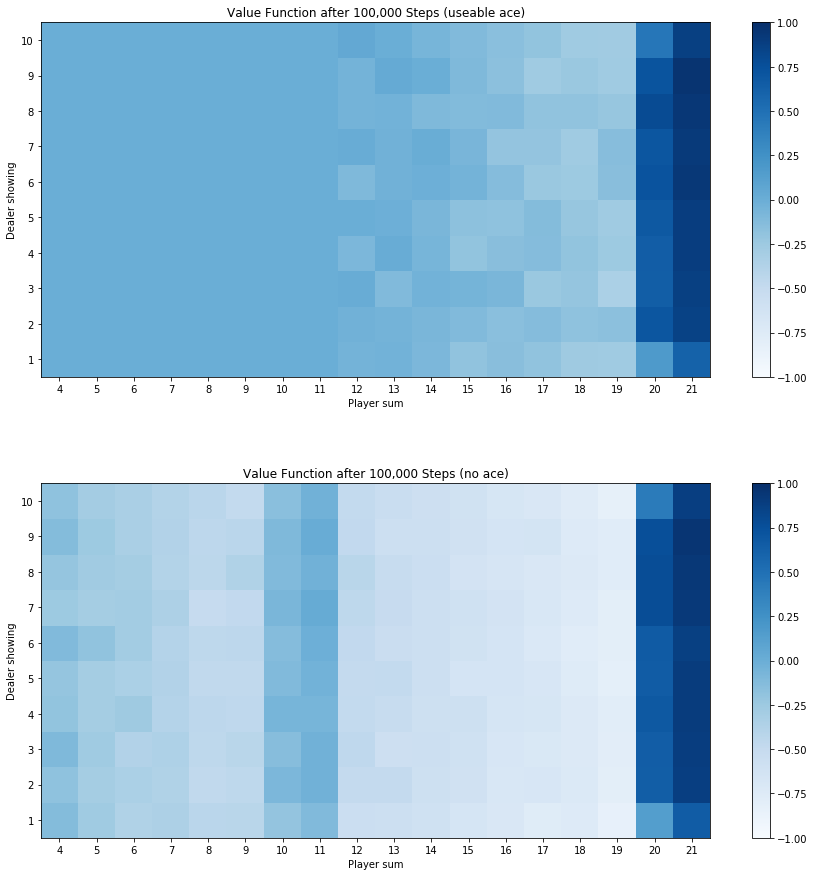

In [18]:
# let's create the example policy
policy = create_example_policy()

# and now let's see how good our policy is
policy_value = mc_policy_evaluation(blackjack_env, policy, num_episodes=100000)       
plot_value_function(policy_value, title="Value Function after 100,000 Steps")

In [19]:
policy_value

defaultdict(float,
            {(21, 6, True): 0.930952380952381,
             (14, 3, False): -0.5569620253164557,
             (10, 3, False): -0.136986301369863,
             (9, 10, False): -0.4768740031897927,
             (4, 10, False): -0.17277486910994763,
             (21, 10, False): 0.8903189703413542,
             (18, 10, False): -0.7573863636363637,
             (14, 1, False): -0.5868596881959911,
             (19, 3, False): -0.7856257744733581,
             (12, 3, False): -0.45936794582392776,
             (17, 10, False): -0.6906517251548215,
             (13, 10, False): -0.5292753623188405,
             (16, 10, False): -0.6673244995771074,
             (20, 10, False): 0.4223133362106172,
             (14, 5, False): -0.5615212527964206,
             (17, 5, False): -0.672566371681416,
             (15, 3, False): -0.5910543130990416,
             (10, 1, False): -0.1958762886597938,
             (20, 1, False): 0.14518900343642613,
             (16, 6, False): -

In [20]:
asdf = np.ones(blackjack_env.action_space.n)

In [21]:
epsilon=0.1
awe = asdf*epsilon

In [22]:
az = awe/blackjack_env.action_space.n

In [23]:
az

array([0.05, 0.05])

## 2.2 Monte Carlo Control (6 Points)
Implement the On-policy every-visit MC control for ε-soft policies algorithm.

In [24]:
def mc_control_epsilon_greedy(env, policy, num_episodes=10000, discount_factor=1.0, epsilon=0.1):
    """
    On-policy every-visit MC control for ε-soft policies algorithm
    Computes an optimal epsilon-greedy policy.
    
    Args:
        env: the openai gym environment
        policy: the policy as a dict with the state being the key, and a numpy array containing probabilities as the value
        num_episodes: number of episodes to sample
        discount_factor: the Lambda discount factor
        epsilon: chance to sample a random action
    
    Returns:
        a tuple (policy, Q)
        policy is a dict in the same format as the input
        Q is a 2d numpy array containing the state-action values
"""
    # Keeps track of sum and count of returns for each state
    # to calculate an average.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    

    def policy_fn(Q,env, obs, epsilon):
        
        props = np.ones(env.action_space.n, dtype = float) *epsilon / (env.action_space.n)
        best_action = np.argmax(Q[obs])
        props[best_action] += 1. - epsilon
        
        return props
    
    blackjack_env.action_space.n
        
        

    
    for i_episode in range(num_episodes):
        
        obs = env.reset()
        episodes = []
        
        for i in range (0, env.action_space.n):
            
            props = policy_fn(Q,env,obs,epsilon)
            action = np.random.choice(np.arange(len(props)), p= props)
            next_obs, reward, done, _ = env.step(action)
            episodes.append((obs, action, reward))
                        
            if done:
                
                break
                
            obs = next_obs
    

        # find the unique observation
    
        pairs = set([(epi[0], epi[1]) for epi in episodes])
        
        for (obs, action) in pairs:
            
            pair = (obs,action)
            
            #To know the first observation identified 
            idx = episodes.index([epi for epi in episodes if epi[0] == obs and epi[1] == action][0])
            
            V = sum([reward[2] * discount_factor ** i for i, reward in enumerate(episodes[idx:])])
        
            returns_sum[pair] += V
            returns_count[pair] += 1.
            
            Q[obs][action] = returns_sum[pair] / returns_count[pair]

    
    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game. One hint: the results may differ slightly from the lecture slides. Do not worry too much about it, but you can always try with a few more samples...

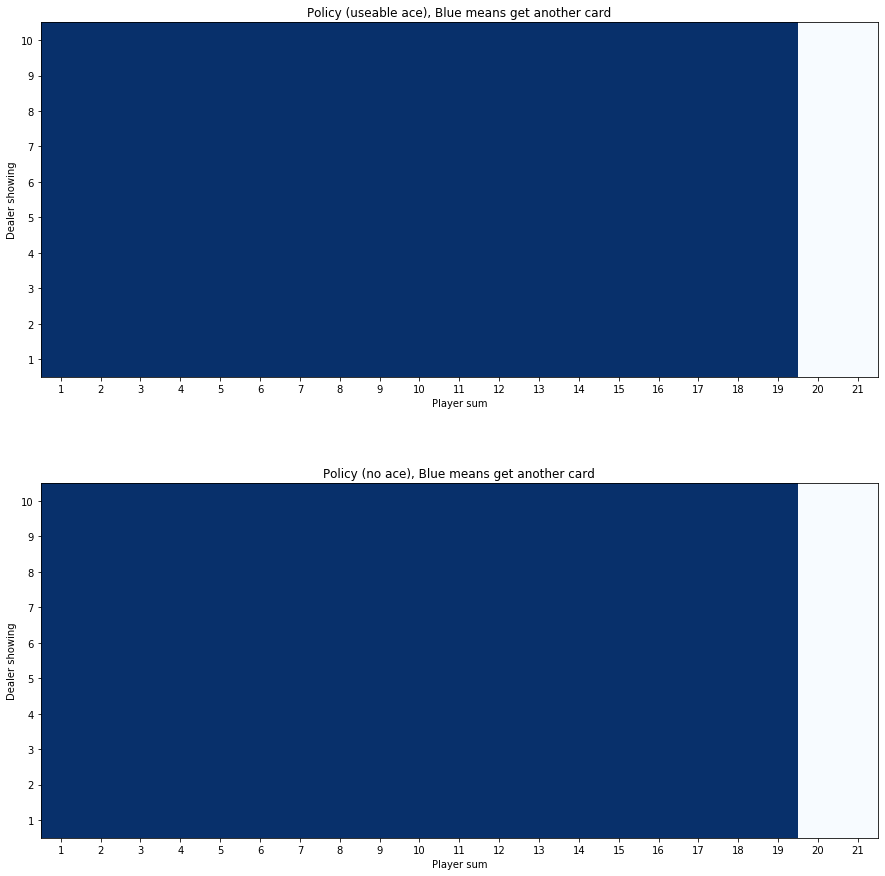

<Figure size 432x288 with 0 Axes>

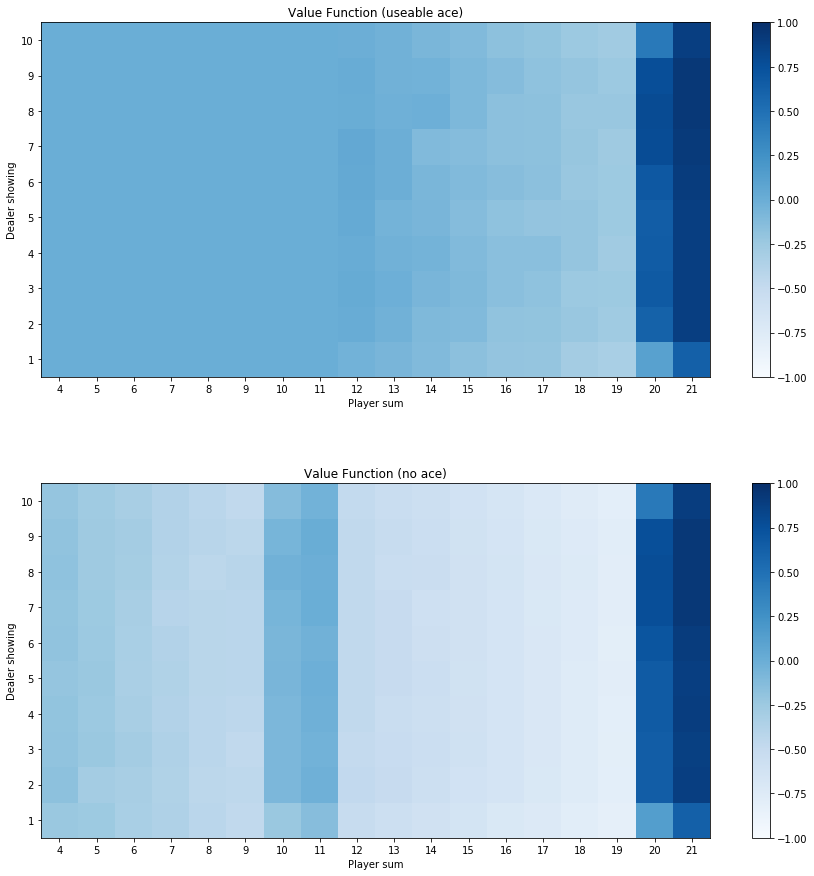

In [25]:
# here, we start from the example policy
policy = create_example_policy()

# and now run our MC control algorithm
policy, Q = mc_control_epsilon_greedy(blackjack_env, policy, 2000000)

# plot the policy
plot_policy(policy)

# how good is our policy?
policy_value = mc_policy_evaluation(blackjack_env, policy, num_episodes=1000000)       
plot_value_function(policy_value)

In [26]:
policy_value

defaultdict(float,
            {(15, 10, False): -0.6131114416411754,
             (21, 10, False): 0.8929266338560147,
             (11, 3, False): -0.035944700460829496,
             (18, 3, False): -0.7480943306336351,
             (20, 3, False): 0.6525466893039049,
             (16, 1, True): -0.20016611295681064,
             (13, 1, True): -0.06823027718550106,
             (14, 9, False): -0.5485194632361096,
             (13, 9, False): -0.5111459616892573,
             (7, 4, False): -0.37196356275303644,
             (14, 4, False): -0.5551318003365115,
             (9, 9, False): -0.43349282296650715,
             (19, 9, False): -0.7811513237794511,
             (16, 10, True): -0.1642588561250742,
             (19, 10, True): -0.2671644213601688,
             (19, 8, True): -0.22595830531271016,
             (17, 8, True): -0.17136659436008678,
             (18, 8, False): -0.7323776803696245,
             (17, 10, True): -0.19478357380688124,
             (16, 8, False):

# Part 3: Frozen Lake Revisited (with Monte Carlo)
We will now go back to the Frozen Lake and run the MC algorithms on this problem. To do so, we need a few convenience function for converting the evaluation function and policy (a dict in the MC algorithms) to arrays, for outputting the data in the same way as with DP.

Spoiler Alert: These experiments will be a bit disappointing... but for some reasons MC does not work well on this problem instance. Why? (You will have to answer this question soon...)

Thus, we will use a smaller version of the frozen lake:

<pre><code>
SFFF
FHFH
FFFH
HFFG
</code>
</pre>

All the rules stay the same.

In [27]:
def dict_to_array_value_function(size, data):
    value_function = np.zeros(size)

    for k, v in data.items():
        value_function[k] = v

    return value_function

def random_policy_frozen_lake(env):
    policy = defaultdict()
    
    for state in range(env.observation_space.n):
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy    

## Run MC Evaluation on the Frozen Lake (small)

### MC Evaluation on the Small Lake

In [28]:
# we start with the smaller lake
small_lake_env = gym.make('FrozenLake-v0')
small_lake_env.reset()
small_lake_env.render()
print("\n")

# let's create a random policy
policy = random_policy_frozen_lake(small_lake_env)

# and now let's see how good our policy is
value = mc_policy_evaluation(small_lake_env, policy, 20000)

value_array = dict_to_array_value_function(small_lake_env.observation_space.n, value)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
print(value_array.reshape((small_lake_env.env.ncol,small_lake_env.env.nrow)))

# what does DP have to say about this small problem?
value = policy_evaluation(small_lake_env, policy)
print("\nThe Value Function of our Policy, according to DP:\n")
print(value.reshape((small_lake_env.env.ncol, small_lake_env.env.nrow)))


SFFF
FHFH
FFFH
HFFG



The Value Function of our Policy, according to MC:

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

The Value Function of our Policy, according to DP:

[[0.0136 0.0114 0.0208 0.0104]
 [0.0161 0.     0.0407 0.    ]
 [0.0347 0.0881 0.142  0.    ]
 [0.     0.1758 0.4393 0.    ]]


### MC Evaluation on the Larger Lake

In [29]:
# well then, let's see what happens when we apply this method to the larger version:

larger_lake_env = gym.make('FrozenLake8x8-v0')
larger_lake_env.reset()
larger_lake_env.render()
print("\n")

# let's create a random policy
policy = random_policy_frozen_lake(larger_lake_env)

# and now let's see how good our policy is
value = mc_policy_evaluation(larger_lake_env, policy, 20000)

value_array = dict_to_array_value_function(larger_lake_env.observation_space.n, value)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
print(value_array.reshape((larger_lake_env.env.ncol,larger_lake_env.env.nrow)))

# what does DP have to say about this small problem?
value = policy_evaluation(larger_lake_env, policy)
print("\nThe Value Function of our Policy, according to DP:\n")
print(value.reshape((larger_lake_env.env.ncol, larger_lake_env.env.nrow)))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



The Value Function of our Policy, according to MC:

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

The Value Function of our Policy, according to DP:

[[0.0011 0.0014 0.0021 0.0034 0.0057 0.0088 0.0124 0.0148]
 [0.001  0.0012 0.0016 0.0025 0.0051 0.0087 0.0137 0.0175]
 [0.0007 0.0008 0.0007 0.     0.0036 0.0071 0.0163 0.0242]
 [0.0005 0.0005 0.0005 0.0007 0.0023 0.     0.0203 0.039 ]
 [0.0003 0.0002 0.0002 0.     0.0048 0.0115 0.0261 0.0724]
 [0.0001 0.     0.     0.0014 0.0054 0.0153 0.     0.1521]
 [0.     0.     0.0001 0.0004 0.     0.0443 0.     0.384 ]
 [0.     0.     0.     0.     0.0539 0.1618 0.3873 0.    ]]


## Run MC Control on the Frozen Lake

### MC Control on the Small Lake

In [30]:
# we start with the smaller lake
small_lake_env = gym.make('FrozenLake-v0')
small_lake_env.reset()
small_lake_env.render()
print("\n")


# let's create a random policy
policy = random_policy_frozen_lake(small_lake_env)

policy, Q = mc_control_epsilon_greedy(small_lake_env, policy, 20000)

print("\nThe computed Policy:\n")
print(deterministic_humanreadable_policy(small_lake_env, policy, move_dict))

# and now let's see how good our policy is
policy_value = mc_policy_evaluation(small_lake_env, policy, 20000)
print("\n")

value_array = dict_to_array_value_function(small_lake_env.observation_space.n, policy_value)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
print(value_array.reshape((small_lake_env.env.ncol,small_lake_env.env.nrow)))

# let's compare this to DP...
#create a random policy
policy = np.ones([small_lake_env.observation_space.n, small_lake_env.action_space.n]) / small_lake_env.action_space.n
policy, value_function = value_iteration(small_lake_env)

print("\nPolicy computed via the value iteration algorithm:\n")
print(deterministic_humanreadable_policy(small_lake_env, policy, move_dict))

print("\nand the respective value function:\n")
print(value_function.reshape((small_lake_env.env.ncol,small_lake_env.env.nrow)))


SFFF
FHFH
FFFH
HFFG



The computed Policy:

[['L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L']]



The Value Function of our Policy, according to MC:

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Policy computed via the value iteration algorithm:

[['L' 'U' 'U' 'U']
 ['L' 'L' 'L' 'L']
 ['U' 'D' 'L' 'L']
 ['L' 'R' 'D' 'L']]

and the respective value function:

[[0.8235 0.8235 0.8235 0.8235]
 [0.8235 0.     0.5294 0.    ]
 [0.8235 0.8235 0.7647 0.    ]
 [0.     0.8824 0.9412 0.    ]]


### MC Control on the Larger Lake

In [31]:
# and now for the bigger problem instance...
larger_lake_env = gym.make('FrozenLake8x8-v0')
larger_lake_env.reset()
larger_lake_env.render()
print("\n")


# let's create a random policy
policy = random_policy_frozen_lake(larger_lake_env)

policy, Q = mc_control_epsilon_greedy(larger_lake_env, policy, 20000)

print("\nThe computed Policy:\n")
print(deterministic_humanreadable_policy(larger_lake_env, policy, move_dict))

# and now let's see how good our policy is
policy_value = mc_policy_evaluation(larger_lake_env, policy, 20000)
print("\n")

print(policy_value)
value_array = dict_to_array_value_function(larger_lake_env.observation_space.n, policy_value)

# print the value function
print("\nThe Value Function of our Policy, according to MC:\n")
print(value_array.reshape((larger_lake_env.env.ncol,larger_lake_env.env.nrow)))

# let's compare this to DP...
#create a random policy
policy = np.ones([larger_lake_env.observation_space.n, larger_lake_env.action_space.n]) / larger_lake_env.action_space.n
policy, value_function = value_iteration(larger_lake_env)

print("\nPolicy computed via the value iteration algorithm:\n")
print(deterministic_humanreadable_policy(larger_lake_env, policy, move_dict))

print("\nand the respective value function:\n")
print(value_function.reshape((larger_lake_env.env.ncol,larger_lake_env.env.nrow)))


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



The computed Policy:

[['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']]


defaultdict(<class 'float'>, {0: 0.0, 8: 0.0, 16: 0.0, 24: 0.0})

The Value Function of our Policy, according to MC:

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

Policy computed via the value iteration algorithm:

[['D' 'R' 'R' 'R' 'R' 'R' 'R' 'R']
 ['U' 'U' 'U' 'U' 'U' 'U' 'U' 'R']
 ['L' 'L' 'L' 'L' 'R' 'U' 'U' 'R']
 ['L' 'L' 'L' 'D' 'L' 'L' 'R' 'R']
 ['L' 'U' 'L' 'L' 'R' 'D' 'U' 'R']
 ['L' 'L' 'L' 'D' 'U' 'L' 'L' 'R']
 ['L' 'L' 'D' 'L' 'L'

# 3.1 Analysis of DP and MC on the Frozen Lake (2 points)

Compare DP and MC on the frozen lake problem. Why is MC not working well?

#### Your Answer:

Because there are several reasons/explanations to support why MC is not suitable for the problem. Monte Carlo algorithm is based on a sampled state-action prediction per episode. As well, the estimation for each state in MC is independent, which is episodic tasks. And, a crucial fact of MC is that this algorithm has to proceed all the way to the end of the episode to the terminal node. Hence, the agent has to learn from experience that can be obtained from interaction with the real environment - state-action pair and average rewards for each action. The policy is updated only at the end of reaching the terminal node for an episode. In the Monte Carlo method, the value function is expected to return from a state its corresponding policy. Thus, it uses approximation by taking the mean return instead of the expected return.

Unlike to MC algorithm, Dynamic Programming needs entire information of the environment or all possible transitions. So, DP algorithm breaks up a problem into relatively smaller ones of overlapping subproblems. After that, it finds the optimal solution to the original problem by aggregating the solution of the subproblems. Due to this reason, DP is quite beneficial to compute optimal policies by being provided with perfect knowledge of the environment. By using bootstrapping to estimate the value of a state, and the algorithm is able to compute the optimal policy through two processes; policy evaluation and policy improvement. 



# Bonus Exercise: TD Learning (up to 10 points, depending on your efforts)

As a bonus exercise, we ask you to try to implement (variations of) TD Learning. It is up to you, how many of the presented algorithms you will try out. What is important though, is an analysis of their behavior on the problem (we suggest you work with the Black Jack environment, but you can also tackle fishlake (or both). Please compare the algorithms to each other as well as to MC Learning. You can earn up to 10 bonus points for this bonus exercise.



In [35]:
blackjack_env = gym.make('Blackjack-v0')
# For calculating 2 steps 
discount_factor = 1.0
alpha=0.1
total_episodes = 100000

In [36]:
# define policy
def get_action_policy(state):
    
    score, dealer_score, usable_ace = state
    
    return np.array([1.0, 0.0]) if score >= 20 else np.array([0.0, 1.0])

In [37]:
def td_prediction(total_episodes):
          
    V = defaultdict(float)
    
    for k in range(1, total_episodes + 1):
        
        current_state = blackjack_env.reset()

        while True:
                
            prob_scores = get_action_policy(current_state)
            current_action = np.random.choice(np.arange(blackjack_env.action_space.n), p=prob_scores)

            next_state, reward, done, _ = blackjack_env.step(current_action)

            td_target = reward + discount_factor * V[next_state]
            td_error = td_target - V[current_state]
            V[current_state] = V[current_state] + alpha * td_error

            if done:
                break

            current_state = next_state
            
    return V

In [38]:
state_value = td_prediction(total_episodes)

In [39]:
state_value

defaultdict(float,
            {(23, 3, False): 0.0,
             (13, 3, False): 33.52121002365929,
             (22, 7, False): 0.0,
             (14, 7, False): 14.691299466618876,
             (16, 9, False): 14.16280512018514,
             (13, 9, False): 13.544603819817187,
             (21, 9, False): 67.60000000000043,
             (20, 4, False): 101.29999999999852,
             (20, 10, False): 250.59999999999005,
             (18, 10, False): 10.160356561021654,
             (19, 10, True): 55.18086612512393,
             (21, 10, False): 265.999999999992,
             (14, 6, False): 16.845659153683442,
             (10, 6, False): 58.76921975376914,
             (17, 6, False): 16.160982426524846,
             (27, 6, False): 0.0,
             (21, 3, False): 71.10000000000024,
             (17, 3, False): 3.1057271934628723,
             (19, 7, False): 7.34055887109425,
             (15, 7, False): 9.059911515622579,
             (23, 7, False): 0.0,
             (22, 1,

In [40]:
# there are two algorithm in Temporal difference control; SARSA (state-action-reward-action)
# another one is Q-learning 

In [41]:
# For Sarsa-TD control
blackjack_env = gym.make('Blackjack-v0')
env = blackjack_env
nA = env.action_space.n
epsilon = 0.1
discount_factor =1.0
alpha = 0.1

def get_epision_greedy_action_policy(Q,observation):
    
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[observation])
    A[best_action] += (1.0 - epsilon)
    
    return A

In [42]:
def sarsa(total_episodes):
    
    Q = defaultdict(lambda: np.zeros(nA))
    
    for k in range(total_episodes):
        
        current_state = env.reset()
        prob_scores = get_epision_greedy_action_policy(Q,current_state)
        current_action = np.random.choice(np.arange(nA), p=prob_scores)
        
        while True:
            next_state, reward, done, _ = env.step(current_action)
            
            prob_scores_next_state = get_epision_greedy_action_policy(Q,next_state)
            next_action = np.random.choice(np.arange(nA), p=prob_scores_next_state)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[current_state][current_action]
            Q[current_state][current_action] = Q[current_state][current_action] + alpha * td_error
    
            if done:
                break
                
            current_state = next_state        
            current_action = next_action
    return Q

In [46]:
values_action_sarsa = sarsa(total_episodes)

In [47]:
values_action_sarsa

defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {(10, 3, False): array([5.0694, 5.7435]),
             (12, 8, False): array([3.5403, 4.7512]),
             (17, 10, False): array([-0.1211, -0.1378]),
             (16, 4, False): array([0.5779, 5.5867]),
             (11, 5, False): array([3.8814, 5.3511]),
             (6, 8, False): array([1.5803, 4.9883]),
             (17, 2, False): array([1.3532, 0.7173]),
             (14, 7, False): array([1.901 , 3.0991]),
             (9, 10, False): array([0.9808, 1.3795]),
             (10, 4, False): array([ 4.7698, 10.0089]),
             (14, 10, False): array([-0.4013,  1.0919]),
             (20, 10, False): array([4.8952, 2.4596]),
             (19, 8, False): array([16.8017,  1.4444]),
             (16, 10, False): array([-0.06,  0.61]),
             (18, 3, True): array([1.271 , 4.9224]),
             (15, 5, False): array([0.2827, 0.5623]),
             (14, 8, True): array([-0.0386,  7.9368]),
             (

In [48]:
# Q-Learning


In [49]:
def get_epision_greedy_action_policy(Q,observation):
    
    A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[observation])
    A[best_action] += (1.0 - epsilon)
    
    return A

In [50]:
def qlearning(total_episodes):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for k in range(total_episodes):
        
        current_state = env.reset()
        
        while True:
            
            prob_scores = get_epision_greedy_action_policy(Q,current_state)
            current_action = np.random.choice(np.arange(nA), p=prob_scores)
            
            next_state, reward, done, _ = env.step(current_action)
            
            best_next_action = np.argmax(Q[next_state])
            
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[current_state][current_action]
            
            Q[current_state][current_action] = Q[current_state][current_action] + alpha * td_error
    
            if done:
                break
                
            current_state = next_state 
            
    return Q

In [51]:
values_action_Q = qlearning(total_episodes)

In [52]:
values_action_Q

defaultdict(<function __main__.qlearning.<locals>.<lambda>()>,
            {(19, 8, False): array([48.2  ,  7.316]),
             (8, 1, False): array([0.977 , 6.4272]),
             (13, 5, False): array([10.103,  9.322]),
             (6, 10, False): array([20.0355, 18.6363]),
             (20, 8, False): array([90.8   ,  4.0517]),
             (11, 2, False): array([15.2303, 15.7466]),
             (20, 9, False): array([96.4   ,  7.1011]),
             (14, 10, False): array([23.1951, 23.0659]),
             (16, 4, False): array([6.7895, 6.8842]),
             (15, 4, False): array([5.2932, 4.7368]),
             (19, 4, False): array([36.    ,  6.8675]),
             (17, 10, False): array([ 3.6072, 53.3129]),
             (14, 5, False): array([ 9.1252, 13.3578]),
             (13, 8, False): array([ 7.2435, 11.2295]),
             (20, 3, False): array([70.9   ,  4.6562]),
             (11, 1, False): array([ 9.6976, 21.6944]),
             (11, 4, False): array([14.991 , 26.81

In reinforcement learning, a Monte Carlo method is used when the model of the environment is not known (Model-free prediction or Model-free Control), which learns directly from raw experience without a model of the environment's dynamics. Otherwise, Dynamic programming is for finding an optimal policy with a fully given information of the environment, where we call model dynamics, which are based on transition and reward probabilities.
The temporal difference can be defined as a combination of Monte Carlo and Dynamic programming. TD uses the bootstrapping method, which is not for updating the global expected reward estimation. In other words, the bootstrapping method is for holding until the next time step to update the value estimates.

SARSA is an on-policy control algorithm. Therefore, in this algorithm, it needs to care on state-action value unlikely a state-value pair by an off-policy (e.g. Q-learning) algorithm. SARSA is convergent to an optimal policy when all stat-action pairs are visited an infinite number of times and the policy converges in the limit to the greedy policy.

Q-learning is treated as an off-policy TD control algorithm. Hence, it is a handy algorithm. In this algorithm, the state-action value pair has the major effect of performing an action (A) in the state(S).

Based on the results from the two chosen TD algorithms, both algorithms significantly outperform the result with the Monte Carlo algorithm. Especially, Q-learning represents outstanding returns over the two comparisons (SARSA and Monte Carlo). To explain for the result, the nature of the Q-learning algorithm is the most suitable for the Blackjack game because this method learns to take place during play. In addition, Q-learning is an episodic task which as the same game rule for Blackjack. 